# 1 - Libraries

In [1]:
#Upload all libraries for NBA Data Analysis
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import boxscoretraditionalv2
from nba_api.stats.endpoints import leaguegamelog
import numpy as np
from tqdm import tqdm

# 2 - NBA_SEASON Class

This Class holds an NBA SEASONS GAMES and can have the following properites:
- Show Box Score
- Show a Lead Tracket Timeline of Points, Rebounds and Assists Differentials

In [2]:
def get_season_games(season):
    # Initialize an empty list to store game data
    all_games = [] 

    # Specify the range of seasons you want to cover
    # For example, from the 1946-47 season to the 2020-21 season
    season_str = f"{season}-{str(season+1)[-2:]}"
    # print(f"Fetching games for season: {season_str}")

    for game_type in ["Playoffs","Regular Season"]:
        # Fetch the game logs for the season
        game_log = leaguegamelog.LeagueGameLog(season=season_str,season_type_all_star=game_type)
        games = game_log.get_data_frames()[0]

        # Append the data to the all_games list
        all_games.append(games)

        # Combine all seasons into a single DataFrame
        all_games_df = pd.concat(all_games, ignore_index=True)
        all_games_df = all_games_df[['GAME_ID',	'GAME_DATE', 'MATCHUP',	'TEAM_ID']]
        all_games_df = all_games_df.sort_values(by=['GAME_DATE','GAME_ID'])

        # Identifying the home and away teams.
        home_team_row = all_games_df[~all_games_df['MATCHUP'].str.contains('@')]
        away_team_row = all_games_df[all_games_df['MATCHUP'].str.contains('@')]

        # Constructing the target DataFrame.
        target_state_data = {
            'GAME_ID': home_team_row['GAME_ID'].values,
            'GAME_DATE': home_team_row['GAME_DATE'].values,
            'MATCHUP': home_team_row['MATCHUP'].str.replace('@', 'vs.').str.strip(),
            'HOMETEAM_ID': home_team_row['TEAM_ID'].values,
            'AWAYTEAM_ID': away_team_row['TEAM_ID'].values
        }

        # Creating the DataFrame for the target state.
        target_df = pd.DataFrame(target_state_data)

    return target_df

In [3]:
# create a loop using the get_all_nba_games function to get games from 2018 to 2023 seasons, each season append them together
def get_multiple_seasons_games(early_season, late_season, filename):
    all_games = pd.DataFrame()
    for season in range(early_season,late_season):
        all_games = pd.concat([all_games, get_all_nba_games(season)])
        # Split the Game Date to Year, Month, Day
        all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])
        all_games['Year'] = all_games['GAME_DATE'].dt.year
        all_games['Month'] = all_games['GAME_DATE'].dt.month
        all_games['Day'] = all_games['GAME_DATE'].dt.day
    
        # adding a column with the season string
        all_games['Season'] = (all_games['Year']-1).astype(str) + '-' + (all_games['Year']).astype(str).str[-2:]

        # save the all_games dataframe to a csv file in data folder with the filename given
        all_games.to_csv(f'data/{filename}.csv', index=False)

In [4]:
def get_seconds_transcurred(pctimestring, quarter):
    mins, secs = pctimestring.split(':')
    if quarter <= 4:
        return (11-int(mins))*60 + (60-int(secs))

    else:
         return (5-int(mins))*60 + int(secs)


def get_seconds_transcurred_total(row, quarter):
    if quarter <= 4:
        return (quarter-1)*12*60 + row['SECONDS_TRANSCURRED_QUARTER']
    else:
        return (4)*12*60 + (quarter-5)*5*60 + row['SECONDS_TRANSCURRED_QUARTER']


def get_lead_score_column(row):
    if row['HOMEDESCRIPTION'] == None:
        return 0
    elif row['VISITORDESCRIPTION'] == None:
        return 1
    else:
        return 2


# add get_seconds_transcurred and get_seconds_transcurred_total to the get_play_by_play_data function
def get_play_by_play_data(game_id):
    play_by_play = playbyplayv2.PlayByPlayV2(game_id=game_id)
    play_by_play = play_by_play.get_data_frames()[0]
    play_by_play['SECONDS_TRANSCURRED_QUARTER'] = play_by_play.apply(lambda x: get_seconds_transcurred(x['PCTIMESTRING'], x['PERIOD']), axis=1)
    play_by_play['SECONDS_TRANSCURRED_TOTAL'] = play_by_play.apply(lambda x: get_seconds_transcurred_total(x, x['PERIOD']), axis=1)

    return play_by_play

In [5]:
# create an unique column of 0 to maximum number of seconds_transcurred_total
def get_unique_seconds_transcurred_total(play_by_play):
    return np.arange(0, play_by_play['SECONDS_TRANSCURRED_TOTAL'].max()+1)

# create a function to split the column 'SCORE' into two columns 'HOME_SCORE' and 'AWAY_SCORE', and HOME_SCORE minus AWAY_SCORE and convert them to integers
def get_score_columns(play_by_play):
    play_by_play['HOME_SCORE'] = pd.to_numeric(play_by_play['SCORE'].str.split(' - ', expand=True)[0], downcast="signed")
    play_by_play['AWAY_SCORE'] = pd.to_numeric(play_by_play['SCORE'].str.split(' - ', expand=True)[1], downcast="signed")
    play_by_play['SCORE_TOTAL'] = play_by_play['HOME_SCORE'] + play_by_play['AWAY_SCORE']
    play_by_play['SCORE_DIFF'] = play_by_play['HOME_SCORE'] - play_by_play['AWAY_SCORE']
    # drop rows with score_diff equal to NaN and reset index
    play_by_play = play_by_play.dropna(subset=['SCORE_DIFF']).reset_index(drop=True)
    
    return play_by_play

# Use get_unique_seconds_transcurred_total and get_score_columns to create a DataFrame with all the unique seconds transcurred and the maximum SCORE_TOTAL at that time
def get_score_at_time(play_by_play):
    unique_seconds = get_unique_seconds_transcurred_total(play_by_play)
    score_at_time = pd.DataFrame(unique_seconds, columns=['SECONDS_TRANSCURRED_TOTAL'])
    score_at_time = score_at_time.merge(play_by_play[['SECONDS_TRANSCURRED_TOTAL','SCORE_TOTAL']], on='SECONDS_TRANSCURRED_TOTAL', how='left')
    score_at_time = score_at_time.fillna(method='ffill')
    score_at_time['SCORE_TOTAL'] = score_at_time['SCORE_TOTAL'].astype(int)
    return score_at_time


In [6]:
pbp = get_play_by_play_data('0021800001')
pbp

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,SECONDS_TRANSCURRED_QUARTER,SECONDS_TRANSCURRED_TOTAL
0,0021800001,2,12,0,1,8:03 PM,12:00,None,Start of 1st Period (8:03 PM EST),None,...,0,0,None,NaN,None,None,None,0,0,0
1,0021800001,4,10,0,1,8:03 PM,12:00,Jump Ball Horford vs. Embiid: Tip to Simmons,None,None,...,5,1627732,Ben Simmons,1.610613e+09,Philadelphia,76ers,PHI,1,0,0
2,0021800001,7,2,1,1,8:03 PM,11:40,None,None,MISS Covington 27' 3PT Jump Shot,...,0,0,None,NaN,None,None,None,1,20,20
3,0021800001,8,4,0,1,8:04 PM,11:40,CELTICS Rebound,None,None,...,0,0,None,NaN,None,None,None,0,20,20
4,0021800001,10,2,1,1,8:04 PM,11:15,MISS Tatum 25' 3PT Jump Shot,None,None,...,0,0,None,NaN,None,None,None,1,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0021800001,704,4,0,4,10:21 PM,0:46,Ojeleye REBOUND (Off:0 Def:1),None,None,...,0,0,None,NaN,None,None,None,1,674,2834
488,0021800001,708,1,6,4,10:21 PM,0:38,Wanamaker 1' Driving Layup (2 PTS),None,None,...,0,0,None,NaN,None,None,None,1,682,2842
489,0021800001,709,2,63,4,10:21 PM,0:22,None,None,MISS McConnell 7' Fadeaway Jumper,...,0,0,None,NaN,None,None,None,1,698,2858
490,0021800001,710,4,0,4,10:22 PM,0:19,Wanamaker REBOUND (Off:0 Def:1),None,None,...,0,0,None,NaN,None,None,None,1,701,2861


In [7]:


# For pbp:
## 1. create df_a with: SECONDS_TRANSCURRED_TOTAL & SCORE_DIFF from pbp
## 2. create df_b with: get_unique_seconds_transcurred_total from pbp
## 3. merge df_b with df_a on SECONDS_TRANSCURRED_TOTAL with how='left'
## 4. fillna with method='ffill'
## 5. convert SCORE_DIFF to int
## 6. return the df

def get_lead_timeline_vector(play_by_play):
    df_a = get_score_columns(play_by_play)[['SECONDS_TRANSCURRED_TOTAL','SCORE_DIFF', 'SCORE_TOTAL']]
    # get df_a with unique seconds transcurred and the maximum SCORE_TOTAL at that time
    df_a = df_a.groupby('SECONDS_TRANSCURRED_TOTAL').agg({'SCORE_DIFF':'last', 'SCORE_TOTAL':'last'}).reset_index()

    # drop SCORE_TOTAL column
    df_a = df_a.drop(columns=['SCORE_TOTAL'])

    df_b = pd.DataFrame(get_unique_seconds_transcurred_total(play_by_play), columns=['SECONDS_TRANSCURRED_TOTAL'])
    score_diff_at_time = df_b.merge(df_a, on='SECONDS_TRANSCURRED_TOTAL', how='left')
    score_diff_at_time = score_diff_at_time.ffill()


    #fill the NaN values with 0
    score_diff_at_time = score_diff_at_time.fillna(0)

    score_diff_at_time['SCORE_DIFF'] = score_diff_at_time['SCORE_DIFF'].astype(int)

    # drop row[0] and reset index
    score_diff_at_time = score_diff_at_time.drop(score_diff_at_time.index[0]).reset_index(drop=True)

    # create an np.array with the values of the SCORE_DIFF column
    score_diff_at_time = score_diff_at_time['SCORE_DIFF'].values

    return score_diff_at_time

get_lead_timeline_vector(pbp).shape

(2880,)

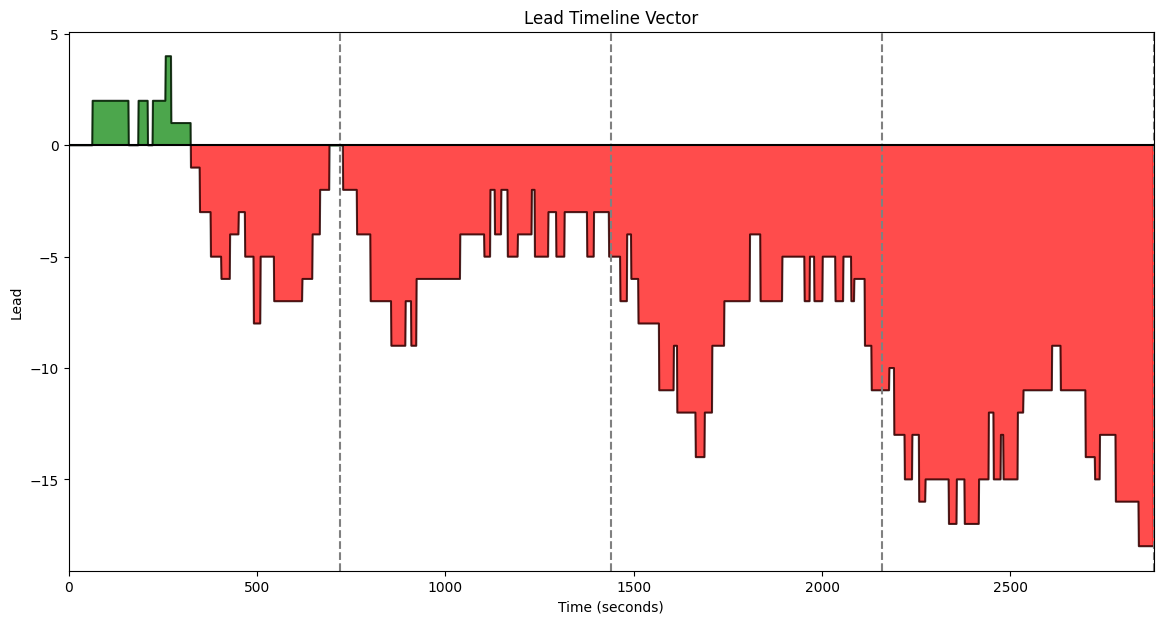

In [8]:
# create a function to plot the lead timeline vector as area with the time in seconds
# function will add home_color and away_color to the plot
# home_color will be green and away_color will be red as default
# home_color for positive values
# away_color for negative values
# at the end of each quarter plot the value of the lead (-1)

def plot_lead_timeline_vector(lead_timeline_vector, home_color='green', away_color='red'):
    plt.figure(figsize=(14,7))
    plt.fill_between(np.arange(0, len(lead_timeline_vector)), lead_timeline_vector, where=lead_timeline_vector>=0, color=home_color, alpha=0.7)
    plt.fill_between(np.arange(0, len(lead_timeline_vector)), lead_timeline_vector, where=lead_timeline_vector<0, color=away_color, alpha=0.7)


    # x-axis will be the time in seconds, with the maximum value as len of the lead_timeline_vector
    # y-axis will be the lead_timeline_vector
    

    plt.xlim(0, len(lead_timeline_vector))
    plt.plot(lead_timeline_vector, color='black', alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Lead')
    plt.title('Lead Timeline Vector')

    #create vertical lines for each quarter (12 minutes)
    for i in range(1,5):
        plt.axvline(x=12*60*i, color='gray', linestyle='--')


    #create horizontal line for the lead = 0
    plt.axhline(y=0, color='black', linestyle='-')


    plt.show()

plot_lead_timeline_vector(get_lead_timeline_vector(pbp))

In [9]:
def get_season_data(season):
    # Initialize an empty list to store game data
    all_games = [] 

    # Specify the range of seasons you want to cover
    # For example, from the 1946-47 season to the 2020-21 season
    season_str = f"{season}-{str(season+1)[-2:]}"
    # print(f"Fetching games for season: {season_str}")

    # Create an empty DataFrame to store the target state
    target_df = pd.DataFrame()


    for game_type in ["Regular Season","Playoffs"]:
        # Fetch the game logs for the season
        game_log = leaguegamelog.LeagueGameLog(season=season_str,season_type_all_star=game_type)
        games = game_log.get_data_frames()[0]

        # Append the data to the all_games list
        all_games.append(games)

        # Combine all seasons into a single DataFrame
        all_games_df = pd.concat(all_games, ignore_index=True)
        # Add columns for the season and the game type
        all_games_df['SEASON'] = season_str
        all_games_df['GAME_TYPE'] = game_type

        # Add columns for the year, month, and day
        all_games_df['GAME_DATE'] = pd.to_datetime(all_games_df['GAME_DATE'])
        all_games_df['YEAR'] = all_games_df['GAME_DATE'].dt.year
        all_games_df['MONTH'] = all_games_df['GAME_DATE'].dt.month
        all_games_df['DAY'] = all_games_df['GAME_DATE'].dt.day

        # Add columns for home and away teams strings (HOME first 3 letters, AWAY last 3 letters)
        all_games_df['HOME_TEAM'] = all_games_df['MATCHUP'].str[0:3]
        all_games_df['AWAY_TEAM'] = all_games_df['MATCHUP'].str[:3]
    
        all_games_df = all_games_df[['GAME_ID','SEASON','GAME_TYPE','GAME_DATE', 'MATCHUP',	'TEAM_ID', 'HOME_TEAM', 'AWAY_TEAM', 'YEAR', 'MONTH', 'DAY']]
        all_games_df = all_games_df.sort_values(by=['GAME_DATE','GAME_ID'])

        # Identifying the home and away teams.
        home_team_row = all_games_df[~all_games_df['MATCHUP'].str.contains('@')]
        away_team_row = all_games_df[all_games_df['MATCHUP'].str.contains('@')]

        # Constructing the target DataFrame.
        target_state_data = {
            'GAME_ID': home_team_row['GAME_ID'].values,
            'GAME_DATE': home_team_row['GAME_DATE'].values,
            'MATCHUP': home_team_row['MATCHUP'].str.replace('@', 'vs.').str.strip(),
            'HOMETEAM_ID': home_team_row['TEAM_ID'].values,
            'AWAYTEAM_ID': away_team_row['TEAM_ID'].values,
            'SEASON': home_team_row['SEASON'].values,
            'GAME_TYPE': home_team_row['GAME_TYPE'].values,
            'HOME_TEAM': home_team_row['HOME_TEAM'].values,
            'AWAY_TEAM': away_team_row['AWAY_TEAM'].values,
            'YEAR': home_team_row['YEAR'].values,
            'MONTH': home_team_row['MONTH'].values,
            'DAY': home_team_row['DAY'].values
        }

        # Append the data to the target DataFrame
        target_df = pd.concat([target_df, pd.DataFrame(target_state_data)], ignore_index=True)

        # Creating the DataFrame for the target state.
        # target_df = pd.DataFrame(target_state_data).reset_index(drop=True)

    return target_df

# create a loop using the get_all_nba_games function to get games from 2018 to 2023 seasons, each season append them together
def get_multiple_seasons_games(early_season, late_season, filename):
    all_games = pd.DataFrame()
    for season in range(early_season,late_season):
        all_games = pd.concat([all_games, get_all_nba_games(season)])
        # Split the Game Date to Year, Month, Day
        all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])
        all_games['Year'] = all_games['GAME_DATE'].dt.year
        all_games['Month'] = all_games['GAME_DATE'].dt.month
        all_games['Day'] = all_games['GAME_DATE'].dt.day
    
        # adding a column with the season string
        all_games['Season'] = (all_games['Year']-1).astype(str) + '-' + (all_games['Year']).astype(str).str[-2:]

        # save the all_games dataframe to a csv file in data folder with the filename given
        all_games.to_csv(f'data/{filename}.csv', index=False)

In [10]:
# Get season data for 2021
season_data = get_season_data(2021)
season_data.head()

,GAME_ID,GAME_DATE,MATCHUP,HOMETEAM_ID,AWAYTEAM_ID,SEASON,GAME_TYPE,HOME_TEAM,AWAY_TEAM,YEAR,MONTH,DAY
0,0022100001,2021-10-19,MIL vs. BKN,1610612749,1610612751,2021-22,Regular Season,MIL,BKN,2021,10,19
1,0022100002,2021-10-19,LAL vs. GSW,1610612747,1610612744,2021-22,Regular Season,LAL,GSW,2021,10,19
2,0022100003,2021-10-20,CHA vs. IND,1610612766,1610612754,2021-22,Regular Season,CHA,IND,2021,10,20
3,0022100004,2021-10-20,DET vs. CHI,1610612765,1610612741,2021-22,Regular Season,DET,CHI,2021,10,20
4,0022100005,2021-10-20,NYK vs. BOS,1610612752,1610612738,2021-22,Regular Season,NYK,BOS,2021,10,20


In [11]:
# Create a get_lead_timeline_vector function for each game of a season
def get_season_lead_timeline_vectors(season_data):
    # create a np.matrix to store the lead timeline vectors
    max_length = 2880
    season_matrix = np.zeros((len(season_data), max_length))
    
    for i, game_id in tqdm(enumerate(season_data['GAME_ID'])):
        # print(str(season_data['GAME_DATE'][i]) + str(season_data['MATCHUP'][i])+str(season_data['GAME_ID'][i]))
        pbp = get_play_by_play_data(game_id)
        lead_timeline_vector = get_lead_timeline_vector(pbp)
        # print(lead_timeline_vector.shape)
        if len(lead_timeline_vector) > max_length:

            #pad season matrix with zeros
            season_matrix = np.pad(season_matrix,
                                   ((0,0),(0,len(lead_timeline_vector)-max_length)), 
                                    'constant')


            # add the lead timeline vector to the season matrix
            season_matrix[i, :len(lead_timeline_vector)] = lead_timeline_vector

            #update max_length
            max_length = len(lead_timeline_vector)

        
        # if a game has a shorter lead timeline vector than max_length
        else:
            # pad the current lead timeline vector with zeros based on the max_length
            lead_timeline_vector = np.pad(lead_timeline_vector, 
                                          (0, max_length-len(lead_timeline_vector)), 
                                          'constant')
            # add the lead timeline vector to the season matrix
            season_matrix[i] = lead_timeline_vector


    return season_matrix

In [14]:
season_data = season_data
a = get_season_lead_timeline_vectors(season_data)
a.shape

0it [00:30, ?it/s]


ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)